Assignment Objective: You are required to design, evaluate, and critically interpret K-Nearest Neighbor(KNN)models on these datasets representing classification and regression tasks. This exercise is intended to build your competency in: 
• Exploratory Data Analysis (EDA) and preprocessing in applied contexts
• Model design decisions informed by empirical evidence
• Strengths and limitations of KNN as a non-parametric algorithm
• Effective communication of machine learning results and domain insights

Question 1:
Download the following dataset (from Kaggle) with 110.527 medical appointments and 14 associated variables (characteristics). Use it to create models that can predict whether a patient will show up for the appointment booked or not.
https://www.kaggle.com/datasets/joniarroba/noshowappointments

Step 1: Importing Libraries and Loading the Dataset

In [40]:
# Importing libraries
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns  # run pip3 install seaborn in terminal if missing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Loading the dataset
path = kagglehub.dataset_download("joniarroba/noshowappointments")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/KaggleV2-May-2016.csv")    # Load the CSV file
df.head() # Display the first few rows

Path to dataset files: /home/user/.cache/kagglehub/datasets/joniarroba/noshowappointments/versions/5


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


2. Exploratory Data Analysis

In [41]:
# Display basic information about the dataset
print("\n 👉🏿 Dataset shape:", df.shape)  # Check the shape of the dataset (rows, columns)

# Count missing values per column
print("\n 👉🏿 Missing values:")
print(df.isnull().sum())

# Check how many patients showed up vs didn't show up
print("\n 👉🏿 Value counts for target column (No-show):")
print(df['No-show'].value_counts())

# Look at unique values in some categorical columns
print("\n👉🏿 Unique values for 'Gender':", df['Gender'].unique())
print("👉🏿 Unique values for 'Neighbourhood':", df['Neighbourhood'].nunique())



 👉🏿 Dataset shape: (110527, 14)

 👉🏿 Missing values:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

 👉🏿 Value counts for target column (No-show):
No-show
No     88208
Yes    22319
Name: count, dtype: int64

👉🏿 Unique values for 'Gender': ['F' 'M']
👉🏿 Unique values for 'Neighbourhood': 81


3. Data Preprocessing & Feature Engineering

In [42]:
# Drop irrelevant features
""" AppointmentID & PatientId are unique identifiers that have no predictive value while ScheduledDay & AppointmentDay are 
datetime columns not relevant for X features. """
X = df.drop(columns=['No-show', 'AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay'])
print(f" Columns for X: {X.columns} \n")  # Display remaining columns after dropping irrelevant ones

# Encode categorical variables (e.g., Gender, Neighbourhood)
for item in X.columns:
    if X[item].dtype == 'object':
        X[item] = X[item].astype('category').cat.codes

# Create the target variable: 1 if no-show, 0 if showed up
y = df['No-show'].map({'Yes': 1, 'No': 0})
print(f" Column for y: {y.name}")  # Display the target column name

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)


 Columns for X: Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'],
      dtype='object') 

 Column for y: No-show


4. KNN Hyperparameter Tuning

In [43]:
"""
Perform hyperparameter tuning using GridSearchCV for KNN to find the best number of neighbors (k). This is done by sampling 
25% of the training data to speed up the process.

If k is too low, the model may overfit and be too sensitive to noise.
If k is too high, the model may underfit and fail to capture local patterns.
Therefore, we search for the optimal k value that balances bias and variance.
"""

param_grid = {'n_neighbors': list(range(3, 11))}    # Define the parameter grid for KNN
knn = KNeighborsClassifier()    # Initialize the KNN classifier
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')  # Perform grid search with cross-validation

# Sample 25% of the training data
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.25, random_state=42)
grid.fit(X_train_sample, y_train_sample)

best_k = grid.best_params_['n_neighbors']   # Get the best number of neighbors from grid search
model = KNeighborsClassifier(n_neighbors=best_k)    # Initialize the KNN model with the best number of neighbors
model.fit(X_train, y_train)  # Full training set

KNeighborsClassifier(n_neighbors=10)

5. Model Evaluation

Sample predictions: [0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     17669
           1       0.39      0.05      0.09      4437

    accuracy                           0.79     22106
   macro avg       0.60      0.51      0.48     22106
weighted avg       0.72      0.79      0.72     22106



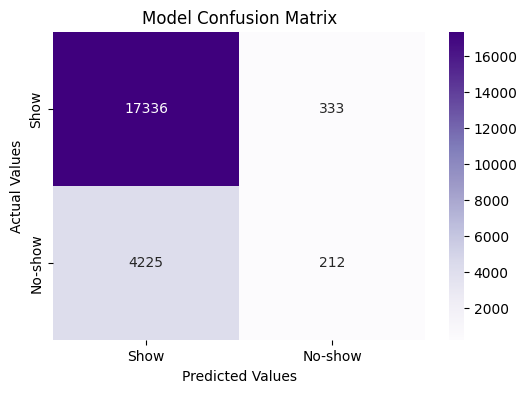

In [44]:
# Generate predictions
y_pred = model.predict(X_test)

# Sample predictions
print(f"Sample predictions: {y_pred[:10]}") # Display the first 10 predictions

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples', xticklabels = ['Show', 'No-show'], yticklabels = ['Show', 'No-show'])
plt.title("Model Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()